# K Means Clustering for Imagery Analysis
### Presented by Eduonix!

In this project, we will use a K-means algorithm to perform image classification.  Clustering isn't limited to the consumer information and population sciences, it can be used for imagery analysis as well. Leveraging Scikit-learn and the MNIST dataset, we will investigate the use of K-means clustering for computer vision.

In this project, we will learn how to:

* Preprocess images for clustering
* Deploy K-means clustering algorithms
* Use common metrics to evaluate cluster performance
* Visualize high-dimensional cluster centroids

Let's get started by importing a few of the libraries we will use in this project.

In [1]:
import sys
import sklearn
import matplotlib
import numpy as np

print('Python: {}'.format(sys.version))
print('Sklearn: {}'.format(sklearn.__version__))
print('Matplotlib: {}'.format(matplotlib.__version__))
print('NumPy: {}'.format(np.__version__))

Python: 3.7.8 (tags/v3.7.8:4b47a5b6ba, Jun 28 2020, 08:53:46) [MSC v.1916 64 bit (AMD64)]
Sklearn: 0.23.2
Matplotlib: 3.3.0
NumPy: 1.18.5


### 1. Import the MNIST dataset

For this project, we will be using the MNIST dataset.  It is available through keras, a deep learning library we have used in previous tutorials. Although we won't be using other features of keras today, it will save us time to import mnist from this library. It is also available through the tensorflow library or for download at http://yann.lecun.com/exdb/mnist/.

In [2]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

print('Training Data: {}'.format(x_train.shape))
print('Training Labels: {}'.format(y_train.shape))

Training Data: (60000, 28, 28)
Training Labels: (60000,)


In [3]:
print('Testing Data: {}'.format(x_test.shape))
print('Testing Labels: {}'.format(y_test.shape))

Testing Data: (10000, 28, 28)
Testing Labels: (10000,)


In [4]:
import matplotlib.pyplot as plt

# python magic function
%matplotlib inline

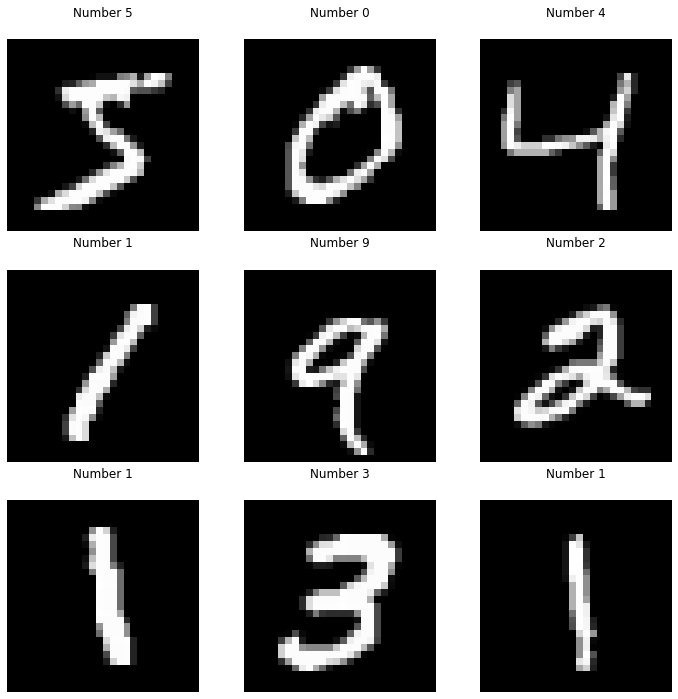

In [17]:
# create figure with 3x3 subplots using matplotlib.pyplot
fig, axs = plt.subplots(3, 3, figsize = (12, 12))
plt.gray()

# loop through subplots and add mnist images
for i, ax in enumerate(axs.flat):
    ax.matshow(x_train[i])
    ax.axis('off')
    ax.set_title('Number {}'.format(y_train[i]))
    
# display the figure
#fig.show()

### 2. Preprocessing the MNIST images

Images stored as NumPy arrays are 2-dimensional arrays.  However, the K-means clustering algorithm provided by scikit-learn ingests 1-dimensional arrays; as a result, we will need to reshape each image.  

Clustering algorithms almost always use 1-dimensional data.  For example, if you were clustering a set of X, Y coordinates, each point would be passed to the clustering algorithm as a 1-dimensional array with a length of two (example: [2,4] or [-1, 4]). If you were using 3-dimensional data, the array would have a length of 3 (example: [2, 4, 1] or [-1, 4, 5]).  

MNIST contains images that are 28 by 28 pixels; as a result, they will have a length of 784 once we reshape them into a 1-dimensional array.  

In [7]:
# preprocessing the images

# convert each image to 1 dimensional array
X = x_train.reshape(len(x_train),-1)
Y = y_train

# normalize the data to 0 - 1
X = X.astype(float) / 255.

print(X.shape)
print(X[0].shape)

(60000, 784)
(784,)


### 3. K-Means Clustering

Time to start clustering! Due to the size of the MNIST dataset, we will use the mini-batch implementation of k-means clustering provided by scikit-learn.  This will dramatically reduce the amount of time it takes to fit the algorithm to the data. 

The MNIST dataset contains images of the integers 0 to 9.  Because of this, let's start by setting the number of clusters to 10, one for each digit. 

In [8]:
from sklearn.cluster import MiniBatchKMeans

n_digits = len(np.unique(y_test))
print(n_digits)

# Initialize KMeans model
kmeans = MiniBatchKMeans(n_clusters = n_digits)

# Fit the model to the training data
kmeans.fit(X)

10


MiniBatchKMeans(n_clusters=10)

In [9]:
kmeans.labels_

array([8, 5, 2, ..., 8, 3, 1])

### 4. Assigning Cluster Labels

K-means clustering is an unsupervised machine learning method; consequently, the labels assigned by our KMeans algorithm refer to the cluster each array was assigned to, not the actual target integer.  To fix this, let's define a few functions that will predict which integer corresponds to each cluster.  

In [10]:
def infer_cluster_labels(kmeans, actual_labels):
    """
    Associates most probable label with each cluster in KMeans model
    returns: dictionary of clusters assigned to each label
    """

    inferred_labels = {}

    for i in range(kmeans.n_clusters):

        # find index of points in cluster
        labels = []
        index = np.where(kmeans.labels_ == i)

        # append actual labels for each point in cluster
        labels.append(actual_labels[index])

        # determine most common label
        if len(labels[0]) == 1:
            counts = np.bincount(labels[0])
        else:
            counts = np.bincount(np.squeeze(labels))

        # assign the cluster to a value in the inferred_labels dictionary
        if np.argmax(counts) in inferred_labels:
            # append the new number to the existing array at this slot
            inferred_labels[np.argmax(counts)].append(i)
        else:
            # create a new array in this slot
            inferred_labels[np.argmax(counts)] = [i]

        #print(labels)
        #print('Cluster: {}, label: {}'.format(i, np.argmax(counts)))
        
    return inferred_labels  

def infer_data_labels(X_labels, cluster_labels):
    """
    Determines label for each array, depending on the cluster it has been assigned to.
    returns: predicted labels for each array
    """
    
    # empty array of len(X)
    predicted_labels = np.zeros(len(X_labels)).astype(np.uint8)
    
    for i, cluster in enumerate(X_labels):
        for key, value in cluster_labels.items():
            if cluster in value:
                predicted_labels[i] = key
                
    return predicted_labels

In [12]:
# test the infer_cluster_labels() and infer_data_labels() functions
cluster_labels = infer_cluster_labels(kmeans, Y)
X_clusters = kmeans.predict(X)
predicted_labels = infer_data_labels(X_clusters, cluster_labels)
print( predicted_labels[:20] )
print (Y[:20])

[3 0 4 1 7 2 1 3 1 5 3 1 3 6 1 7 2 5 1 5]
[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9]


### 5. Optimizing and Evaluating the Clustering Algorithm

With the functions defined above, we can now determine the accuracy of our algorithms.  Since we are using this clustering algorithm for classification, accuracy is ultimately the most important metric; however, there are other metrics out there that can be applied directly to the clusters themselves, regardless of the associated labels. Two of these metrics that we will use are inertia and homogeneity. 

Furthermore, earlier we made the assumption that K = 10 was the appropriate number of clusters; however, this might not be the case.  Let's fit the K-means clustering algorithm with several different values of K, than evaluate the performance using our metrics. 

In [13]:
from sklearn import metrics

def calculate_metrics(estimator, data, labels):

    # Calculate and print metrics
    print('Number of Clusters: {}'.format(estimator.n_clusters))
    print('Inertia: {}'.format(estimator.inertia_))
    print('Homogeneity: {}'.format(metrics.homogeneity_score(labels, estimator.labels_)))

In [14]:
clusters = [10, 16, 36, 64, 144, 256]

# test different numbers of clusters
for n_clusters in clusters:
    estimator = MiniBatchKMeans(n_clusters = n_clusters)
    estimator.fit(X)
    
    # print cluster metrics
    calculate_metrics(estimator, X, Y)
    
    # determine predicted labels
    cluster_labels = infer_cluster_labels(estimator, Y)
    predicted_Y = infer_data_labels(estimator.labels_, cluster_labels)
    
    # calculate and print accuracy
    print('Accuracy: {}\n'.format(metrics.accuracy_score(Y, predicted_Y)))

Number of Clusters: 10
Inertia: 2364768.995797825
Homogeneity: 0.46276546332982854
Accuracy: 0.5634833333333333

Number of Clusters: 16
Inertia: 2204484.8045808505
Homogeneity: 0.5610898969927267
Accuracy: 0.6341166666666667

Number of Clusters: 36
Inertia: 1958066.2257443157
Homogeneity: 0.6787457480115976
Accuracy: 0.7516

Number of Clusters: 64
Inertia: 1806727.982774828
Homogeneity: 0.7381655554100484
Accuracy: 0.8078333333333333

Number of Clusters: 144
Inertia: 1633238.111511728
Homogeneity: 0.8054272386374365
Accuracy: 0.8642666666666666

Number of Clusters: 256
Inertia: 1514812.312105421
Homogeneity: 0.8368188109556913
Accuracy: 0.8874166666666666



In [15]:
# test kmeans algorithm on testing dataset
# convert each image to 1 dimensional array
X_test = x_test.reshape(len(x_test),-1)

# normalize the data to 0 - 1
X_test = X_test.astype(float) / 255.

# initialize and fit KMeans algorithm on training data
kmeans = MiniBatchKMeans(n_clusters = 256)
kmeans.fit(X)
cluster_labels = infer_cluster_labels(kmeans, Y)

# predict labels for testing data
test_clusters = kmeans.predict(X_test)
predicted_labels = infer_data_labels(kmeans.predict(X_test), cluster_labels)
    
# calculate and print accuracy
print('Accuracy: {}\n'.format(metrics.accuracy_score(y_test, predicted_labels)))

Accuracy: 0.9012



### 6. Visualizing Cluster Centroids

The most representative point within each cluster is called the centroid. If we were dealing with X,Y points, the centroid would simply be a point on the graph. However, since we are using arrays of length 784, our centroid is also going to be an array of length 784.  We can reshape this array back into a 28 by 28 pixel image and plot it. 

These graphs will display the most representative image for each cluster. 

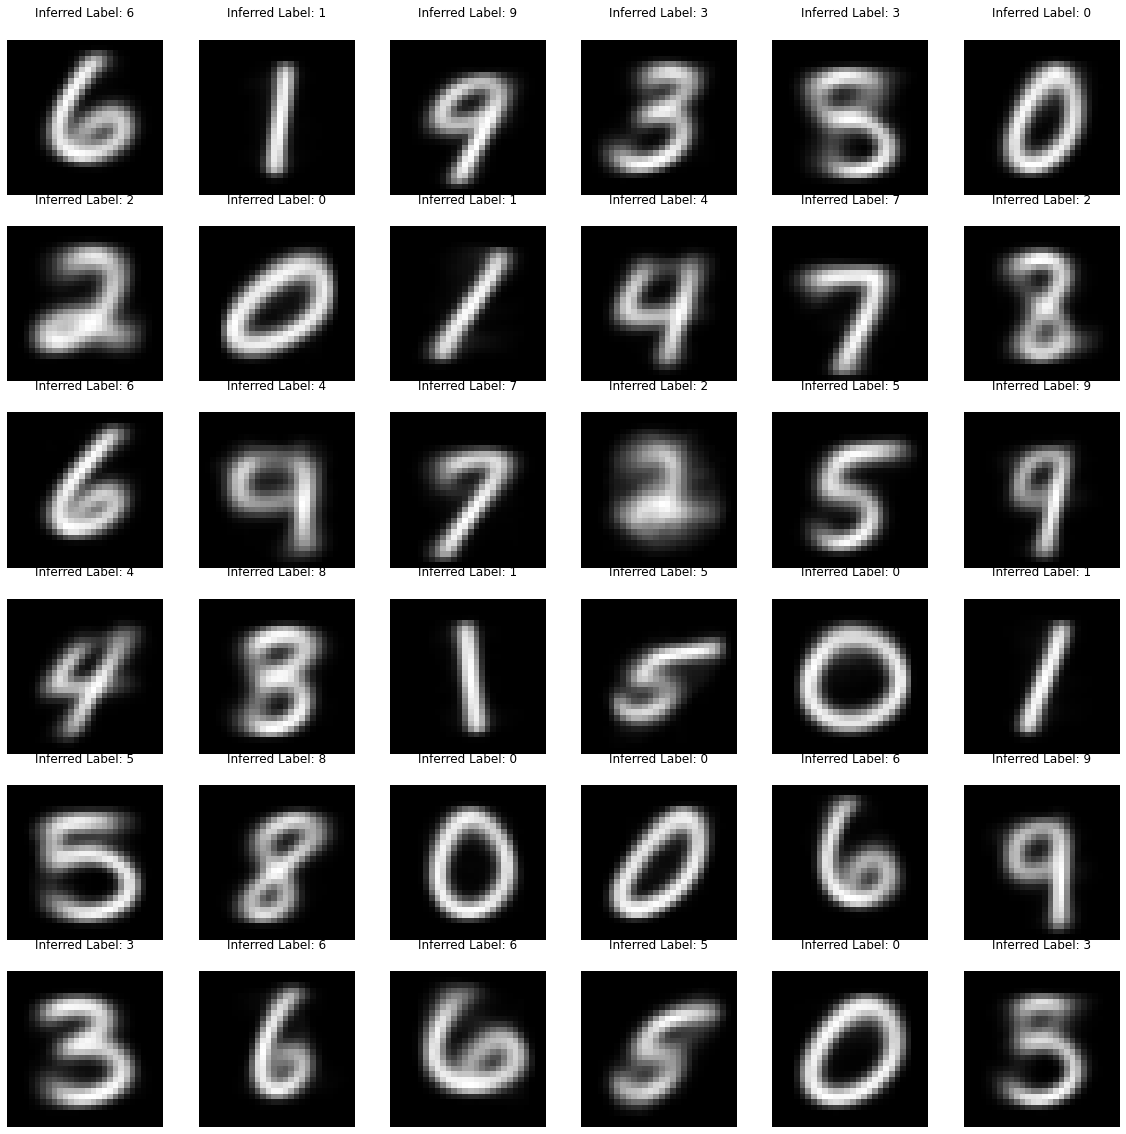

In [18]:
# Initialize and fit KMeans algorithm
kmeans = MiniBatchKMeans(n_clusters = 36)
kmeans.fit(X)

# record centroid values
centroids = kmeans.cluster_centers_

# reshape centroids into images
images = centroids.reshape(36, 28, 28)
images *= 255
images = images.astype(np.uint8)

# determine cluster labels
cluster_labels = infer_cluster_labels(kmeans, Y)

# create figure with subplots using matplotlib.pyplot
fig, axs = plt.subplots(6, 6, figsize = (20, 20))
plt.gray()

# loop through subplots and add centroid images
for i, ax in enumerate(axs.flat):
    
    # determine inferred label using cluster_labels dictionary
    for key, value in cluster_labels.items():
        if i in value:
            ax.set_title('Inferred Label: {}'.format(key))
    
    # add image to subplot
    ax.matshow(images[i])
    ax.axis('off')
    
# display the figure
#fig.show()